<a href="https://colab.research.google.com/github/donw7/neural_activity_models_DNNs/blob/main/decode_behavior_from_neural_activity_DNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decoding decision-making behavior from neural activity
This is a comparison of statistical models vs. deep neural networks (DNNs), their performances across different conditions and with various hyperparameters and types of neural data enabled by recent advances in cellular-resolution, brain-wide imaging.

## Hypotheses:
1. Decision-making behavior can be predicted reasonably well from information encoded in neural activity, even with small datasets
2. DNNs outperform statistical models but are prone to overfitting and require additional considerations, e.g. regularization

## Procedures:
1. Simulate neural data as validation of models to be used later with more complicated real neural data
2. Apply logistic regression
3. Apply recurrent neural networks (RNNs) and other DNNs
4. Compare DNNs to statistical models
5. Experimentation with optimizing hyperparameters

## Results & Conclusions summary:
- Complicated decision-making behavior can be predicted reasonably well from information encoded in neural activity, even with small and potentially noisy real-world datasets
- Interestingly, this suggests cellular information integrated across brain regions may work together for decision-making, a phenomenon that was previously technologically inaccessible
- DNNs outperform statistical models (logistic regression accuracy 30-40% whereas DNNs 50-60% vs. 30% expected by chance)
- DNNS are prone to overfitting and require additional considerations, e.g. crossvalidation or regularization
- XGBoost appears to be the best performing DNN (67% accuracy vs. 30% expected by chance)

## Future directions:
- further validation
- more systmatic hyperparameter tuning, e.g. grid search
- compare with other models, e.g. KNNs, SVM
- generalize to other types of data and conditions, such as EEG data in decision-making tasks
- prediction of real-time dynamics and how this may affect the performance of DNNs, e.g. less structural and more sequential information

## Acknowledgements:
- basic notebook adapted from KordingLab, with added data, analyses, and custom scripts, visualizations
- real neural activity data from Steinmetz et al., 2019

# Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
import warnings

import sklearn

In [2]:
# custom modules
import generate
import decoders
warnings.filterwarnings('ignore')
import myplotfns
import mycrossval



# simulate neural data as validation
Since the goal is to analyze complicated real neural data, which would be less well-validated and subject to more noisy real world conditions, it would be prudent to start with analysis of a simple datasets such as simulated data to validate the models first - technical issues can thus be ruled out if results are negative.

In [3]:
# generate some simulated trial & neural data (drift diffusion model)
n_trials = 250
n_neurons = 10
n_bins_per_trial = 50

neural_recordings, decisions = generate.neural_data(n_trials,
                                                    n_neurons,
                                                    n_bins_per_trial)

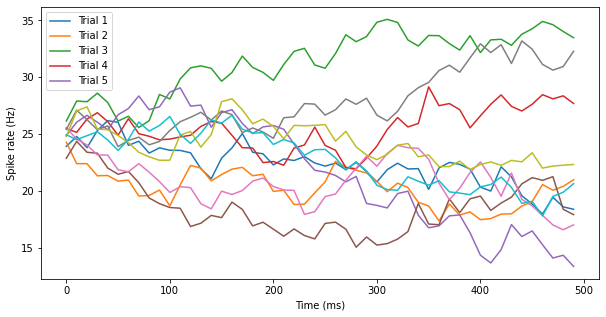

In [4]:
# plot out some trials for one neuron
neuron_id = 0

plt.figure(figsize=(10,5))
plt.plot(np.arange(0,500,10),neural_recordings[:10,neuron_id,:].T)
plt.xlabel("Time (ms)")
plt.ylabel("Spike rate (Hz)")
plt.legend(["Trial {}".format(i) for i in range(1,6)])

# Test initial models 

In [5]:
from sklearn import linear_model

In [6]:
# predict each decision using all neurons's activity throughout the trials

# linear regression
X = np.reshape(neural_recordings, (n_trials,-1))
my_naive_model = linear_model.LinearRegression()

# fit
my_naive_model.fit(X, decisions)

#score
print("R2 was", my_naive_model.score(X,decisions))

# generate a second set of test data
new_neural_recordings, new_decisions = generate.neural_data(n_trials, 
                                             n_neurons, n_bins_per_trial)

new_X = np.reshape(new_neural_recordings, (n_trials,-1))

# score
print("R2 was",my_naive_model.score(new_X,new_decisions))

R2 was 1.0
R2 was 0.1367494379942522


In [7]:
# logistic regression model
log_reg = linear_model.LogisticRegression(penalty='none', solver = 'lbfgs',
                                          max_iter = 1000)
# fit
log_reg.fit(new_X, new_decisions)

# score
print("R2 was",log_reg.score(new_X,new_decisions))

R2 was 1.0


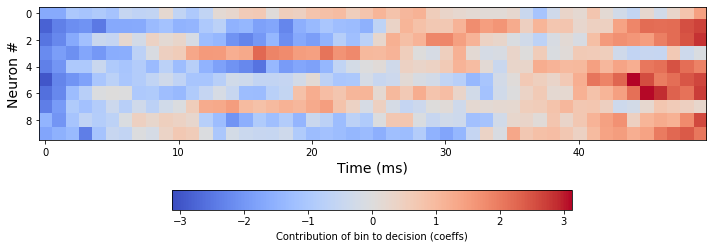

In [8]:
import importlib
importlib.reload(myplotfns)

# plot as heatmap
myplotfns.plot_coefs(log_reg, n_neurons, n_bins_per_trial)

# Crossvalidation setup

In [9]:
# approx 80/20 
# split = int(n_trials*4/5)

# obtain k-fold cross validation splits
(training_X, training_Y), (val_sets, val_Ys) = mycrossval.get_test_train_splits(X, decisions)

# Train and initial test on linear models

In [10]:
scores = []

# Iterate through the k=5 folds
for fold in range(5):
  print("Fold {} of 5".format(fold))
  
  training_Xi = training_X[fold]
  training_Yi = training_Y[fold]
  
  validation_X = val_sets[fold]
  validation_Y = val_Ys[fold]
  
  # re-initialize the logistic regression model
  logreg_model = linear_model.LogisticRegression(penalty='none', solver = 'lbfgs',
                                               max_iter = 1000)
  # fit and score on training
  logreg_model.fit(training_X, training_Y)
  logreg_model.score(training_X,training_Y)

  # score on the validation data
  this_accuracy = logreg_model.score(validation_X,validation_Y)
  scores.append(this_accuracy)
  
  accuracy_on_test_data = logreg_model.score(new_X,new_decisions)
  
  print("   Validation accuracy of {}".format( this_accuracy ))
  print("   True test set accuracy of {}".format( accuracy_on_test_data ))
  plot_coefs(logreg_model)
  
print("Mean validation accuracy: {}".format(np.mean(scores)))

Fold 0 of 5


ValueError: Found array with dim 3. Estimator expected <= 2.

## Experiment with regularization
As small datasets to start with potentially outsized noise, would like to implement regularization and compare for any initially obvious anomalies. 

### try initial value

Fold 0 of 5
   Validation accuracy of 0.76
   True test set accuracy of 0.804


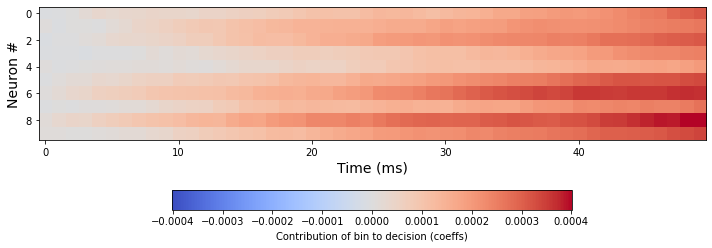

Fold 1 of 5
   Validation accuracy of 0.94
   True test set accuracy of 0.912


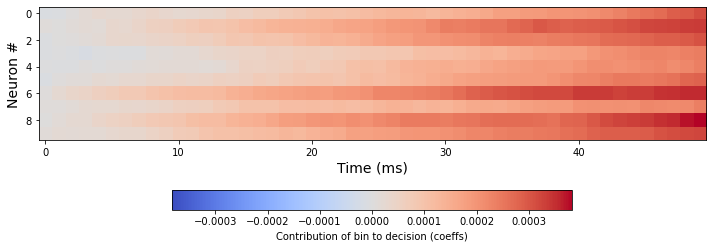

Fold 2 of 5
   Validation accuracy of 0.92
   True test set accuracy of 0.924


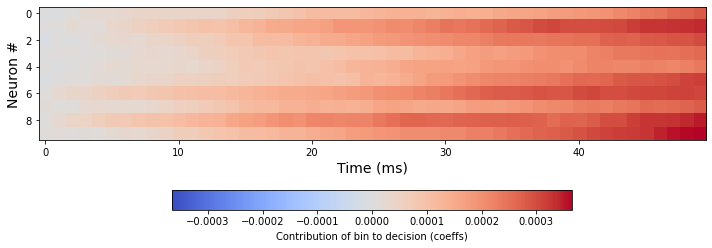

Fold 3 of 5
   Validation accuracy of 0.92
   True test set accuracy of 0.884


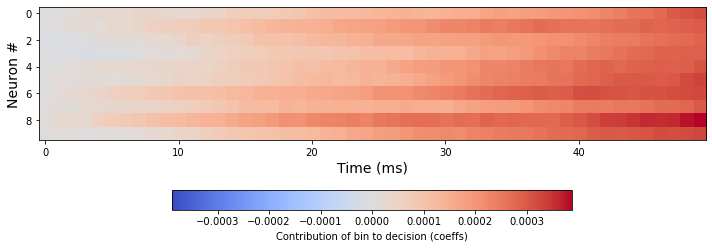

Fold 4 of 5
   Validation accuracy of 0.92
   True test set accuracy of 0.952


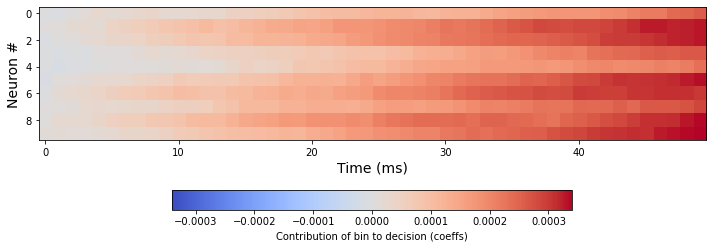

Mean validation accuracy: 0.892


In [ ]:
scores = []

# Iterate through the k=5 folds
for fold in range(5):
    print("Fold {} of 5".format(fold))

    training_Xi = training_X[fold]
    training_Xi = training_Y[fold]

    validation_X = val_sets[fold]
    validation_Y = val_Ys[fold]

    logreg_model = linear_model.LogisticRegression(penalty='l2', solver = 'lbfgs',
                                                 max_iter = 1000, C=1e-6)
    # fit and score on training
    logreg_model.fit(training_Xi, training_Y)
    logreg_model.score(training_Xi,training_Y)

    # score on the validation data
    accuracy = logreg_model.score(validation_X,validation_Y)
    scores.append(accuracy)

    # score on the new dataset (new_X, new_decisions from above)
    accuracy_on_test_data = logreg_model.score(new_X,new_decisions)

    print("   Validation accuracy of {}".format( accuracy ))
    print("   True test set accuracy of {}".format( accuracy_on_test_data ))
    myplotfns.plot_coefs(logreg_model, n_neurons, n_bins_per_trial)

print("Mean validation accuracy: {}".format(np.mean(scores)))

### Choose the best regularization penalty, 'C'
Test various values of `C` and see what's the best.

In [ ]:
def get_kfold_validation_score(data, decisions, C):
  (training_sets, training_Ys), (val_sets, val_Ys) = get_test_train_splits(data, decisions)

  scores = []

# Iterate through the k=5 folds
  for fold in range(5):
    training_X = training_sets[fold]
    training_Y = training_Ys[fold]

    validation_X = val_sets[fold]
    validation_Y = val_Ys[fold]

    # Redefine the logistic regression model. (important to do this inside the loop)
    logreg_model = linear_model.LogisticRegression(penalty='l2', solver = 'lbfgs',
                                                max_iter = 1000, C=C)
    # fit and score on training
    logreg_model.fit(training_X, training_Y)
    logreg_model.score(training_X,training_Y)

    # score on the validation data
    accuracy = logreg_model.score(validation_X,validation_Y)
    scores.append(accuracy)

    # score on the new dataset (new_X, new_decisions from above)
    accuracy_on_test_data = logreg_model.score(new_X,new_decisions)  

      
  return np.mean(scores)

In [ ]:
importlib.reload(mycrossval)

# decide on a logarithmic schedule of Cs. 
Cs_to_test = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]

validation_accuracy_vs_C = []
for C in Cs_to_test:
  
  # get the mean score on k-fold cross-validation using your function above
  mean_validation_accuracy = mycrossval.get_kfold_validation_score(new_X, new_decisions, C)
  
  validation_accuracy_vs_C.append(mean_validation_accuracy)
  
  

(0.8, 1.0)

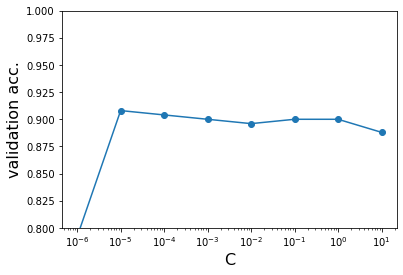

In [ ]:
# plot
plt.semilogx(Cs_to_test, validation_accuracy_vs_C,"o-")
plt.xlabel("C",fontsize=16)
plt.ylabel("validation acc.",fontsize=16)
plt.ylim([.8,1])

c=1e-5 appears to be most optimal, appears to make stepwise change but otherwise no major difference

# Applying recurrent neural networks


The shape of the training inputs is now **3-dimensional** to model effect of time. n_trials x n_neurons x n_timebins

In [ ]:
# lets re-split our original 3-dimensional trials/neurons/time input data.
# split = int(n_trials*4/5)

training_data = neural_recordings[:split]
validation_data = neural_recordings[split:]

training_decisions = decisions[:split]
validation_decisions = decisions[split:]

training_data = np.swapaxes(training_data, 1, 2)
validation_data = np.swapaxes(validation_data, 1, 2)

print("Training input data is of shape", training_data.shape)
print("Validation input data is of shape", validation_data.shape)


In [ ]:
# instantiate the decoder
my_RNN_classifier = decoders.SimpleRNNClassification(units = 50,
                                                    dropout = 0,
                                                    num_epochs =250,
                                                    verbose = 1)

In [ ]:
# fit
my_RNN_classifier.fit(training_data, training_decisions)

In [ ]:
# predict
predictions = my_RNN_classifier.predict(validation_data)
predictions

In [ ]:
#my_RNN_classifier.score(validation_data, validation_decisions)
accuracy = np.sum(predictions == validation_decisions) / len(predictions)
print(accuracy)


# Compare linear and DNN models on real neural data

Neuropixels recordings from Steinmetz et al., 2019 of mice engaging in visual decision-making task. Will try to predict choices from 1 s of neural activity prior to choice. 

"Mice earned water rewards by turning a wheel to indicate which of two visual gratings had higher contrast, or by not turning if no stimulus was presented. When stimuli had equal contrast, a left or right choice was rewarded with 50% probability."

Paradigm: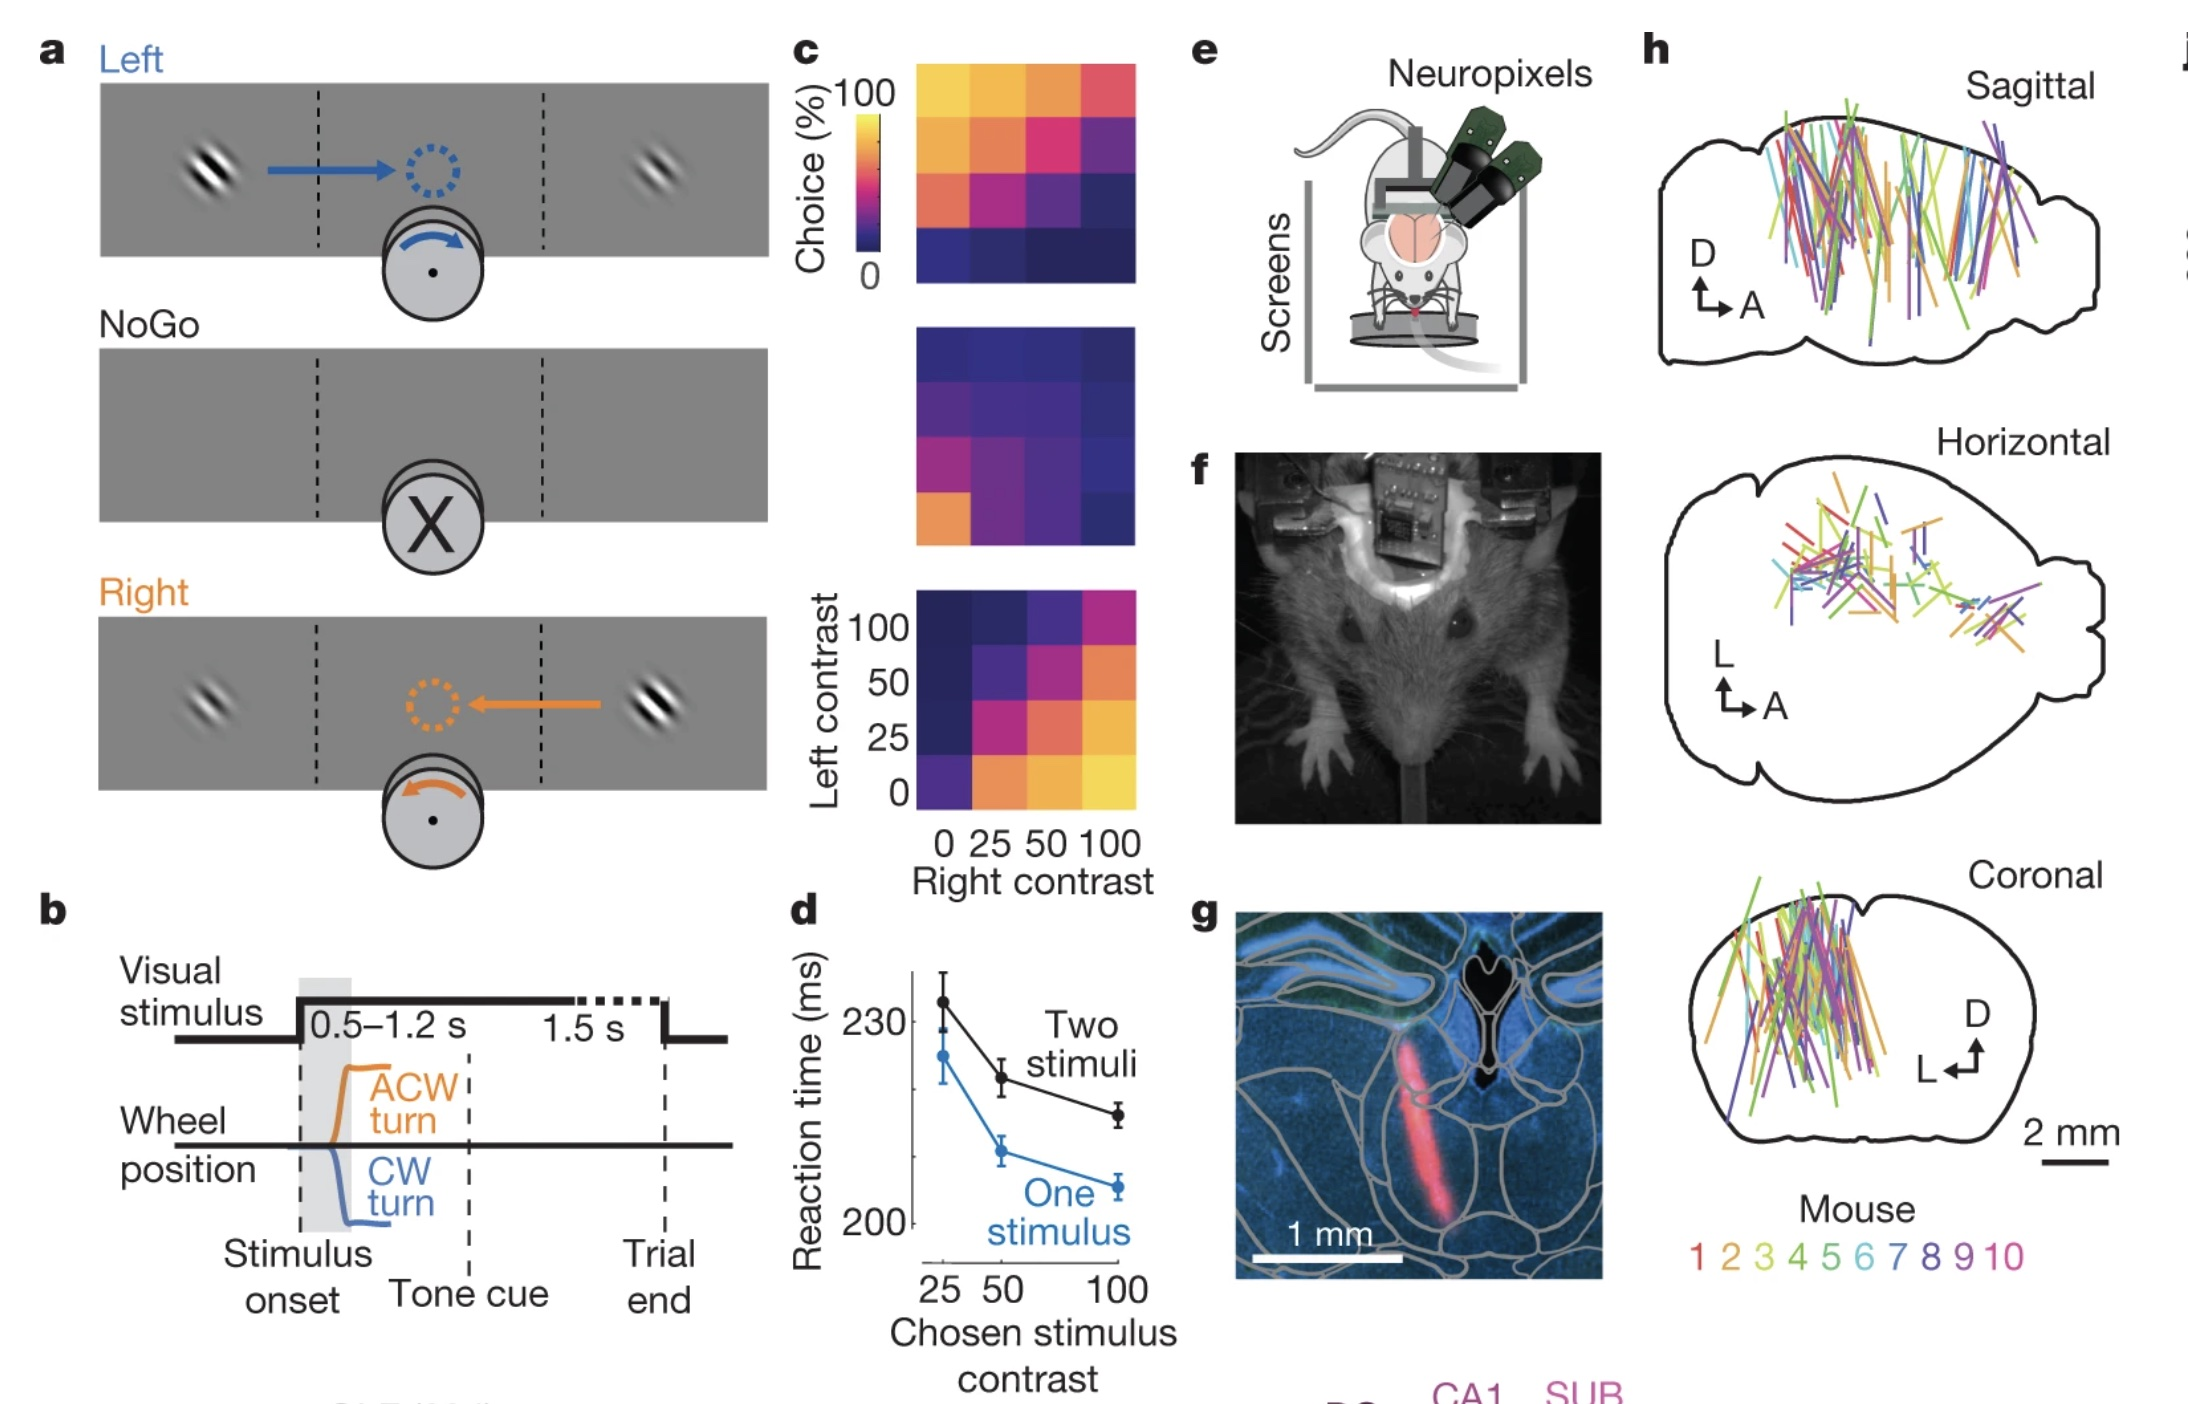

## download data

In [ ]:
!pip install googledrivedownloader

from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1W3TwEtC0Z6Qmbfuz8_AWRiQHfuDb9FIS',
                                    dest_path='./Binned_data.zip',
                                    unzip=True)


Unzipping...Done.


In [ ]:
binned_spikes = np.load('binned_spikes.npy')
choices = np.load('choices.npy')+1
print(binned_spikes.shape, choices.shape)
print(choices[:10])


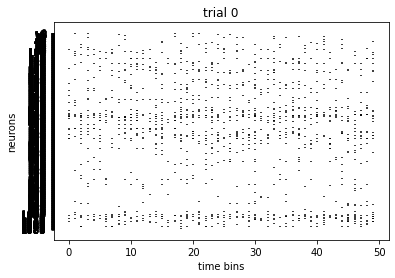

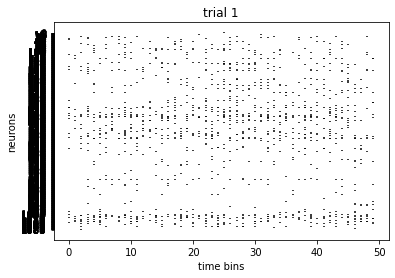

In [ ]:
# print binned spikes event plots
displayidx = range(2) # trial indices to display
for di in displayidx:
  df_spikes_trial = pd.DataFrame(binned_spikes[di,:,:].T)
  positions = df_spikes_trial.apply(lambda x: df_spikes_trial.index[x == 1])
  plt.figure(di)
  plt.eventplot(positions, linelengths=2, lineoffsets=1, colors='black')
  plt.yticks(range(positions.index.size), positions.index)
  plt.gca().invert_yaxis()
  plt.ylabel('neurons')
  plt.xlabel('time bins')
  plt.title(f'trial {di}')

There are 228 trials, 1089 neurons, and 50 bins per trial (for a time of 20ms per bin).



In [ ]:
# split training and validation data
split = int(len(binned_spikes)*4/5)

training_spikes = binned_spikes[:split]
validation_spikes = binned_spikes[split:]

training_choices = choices[:split]
validation_choices = choices[split:]

In [ ]:
my_RNN_classifier = decoders.SimpleRNNClassification(units = 100,
                                                    dropout = 0,
                                                    num_epochs =10,
                                                    verbose = 1)

my_RNN_classifier.fit(training_spikes, training_choices)


predictions = my_RNN_classifier.predict(validation_spikes)
accuracy = np.sum(predictions == validation_choices) / float(len(predictions))

print("\n validation accuracy: {} %".format(100*accuracy))


2022-01-10 18:25:30.227437: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
6/6 [==============================] - 3s 197ms/step - loss: 1.0670 - accuracy: 0.3901
Epoch 2/10
6/6 [==============================] - 1s 184ms/step - loss: 0.8728 - accuracy: 0.6374
Epoch 3/10
6/6 [==============================] - 1s 198ms/step - loss: 0.7319 - accuracy: 0.7308
Epoch 4/10
6/6 [==============================] - 1s 198ms/step - loss: 0.6048 - accuracy: 0.8187
Epoch 5/10
6/6 [==============================] - 1s 195ms/step - loss: 0.4906 - accuracy: 0.8681
Epoch 6/10
6/6 [==============================] - 1s 183ms/step - loss: 0.3943 - accuracy: 0.9066
Epoch 7/10
6/6 [==============================] - 1s 180ms/step - loss: 0.3264 - accuracy: 0.9505
Epoch 8/10
6/6 [==============================] - 1s 182ms/step - loss: 0.2456 - accuracy: 0.9835
Epoch 9/10
6/6 [==============================] - 1s 205ms/step - loss: 0.1906 - accuracy: 0.9945
Epoch 10/10
6/6 [==============================] - 1s 188ms/step - loss: 0.1537 - accuracy: 0.9890

 validation accura

Fit each of the following decoders:

1.   A Gated Recurrent Unit (`decoders.GRUClassification`)
2.   An LSTM (`decoders.LSTMClassification`)
3.   Gradient boosted trees (XGBoost) (`decoders.XGBoostClassification`)





In [ ]:
# GRU
GRU_classifier = decoders.GRUClassification(units = 100,
                                              dropout = .1,
                                              num_epochs = 20,
                                              verbose = 1)

GRU_classifier.fit(training_spikes, training_choices)


Epoch 1/20
6/6 [==============================] - 8s 850ms/step - loss: 1.0650 - accuracy: 0.4725
Epoch 2/20
6/6 [==============================] - 5s 791ms/step - loss: 1.0280 - accuracy: 0.4725
Epoch 3/20
6/6 [==============================] - 5s 832ms/step - loss: 0.9997 - accuracy: 0.4725
Epoch 4/20
6/6 [==============================] - 5s 830ms/step - loss: 0.9777 - accuracy: 0.4945
Epoch 5/20
6/6 [==============================] - 5s 802ms/step - loss: 0.9550 - accuracy: 0.5055
Epoch 6/20
6/6 [==============================] - 5s 766ms/step - loss: 0.9344 - accuracy: 0.5714
Epoch 7/20
6/6 [==============================] - 5s 797ms/step - loss: 0.9160 - accuracy: 0.5659
Epoch 8/20
6/6 [==============================] - 5s 769ms/step - loss: 0.8843 - accuracy: 0.5989
Epoch 9/20
6/6 [==============================] - 5s 795ms/step - loss: 0.8629 - accuracy: 0.5769
Epoch 10/20
6/6 [==============================] - 5s 769ms/step - loss: 0.8583 - accuracy: 0.6264
Epoch 11/20
6/6 [==

In [ ]:
# accuracy 
predictions = GRU_classifier.predict(validation_spikes)
accuracy = np.sum(predictions == validation_choices) / len(predictions)
print(accuracy)


0.21739130434782608


In [ ]:
#LSTM
LSTM_classifier = decoders.LSTMClassification(units = 100, 
                                              dropout = 0.1,
                                              num_epochs = 20,
                                              verbose = 1)

LSTM_classifier.fit(training_spikes, training_choices)

Epoch 1/20
6/6 [==============================] - 9s 973ms/step - loss: 1.0789 - accuracy: 0.4011
Epoch 2/20
6/6 [==============================] - 6s 975ms/step - loss: 1.0146 - accuracy: 0.4725
Epoch 3/20
6/6 [==============================] - 6s 949ms/step - loss: 1.0316 - accuracy: 0.4780
Epoch 4/20
6/6 [==============================] - 5s 874ms/step - loss: 0.9672 - accuracy: 0.4835
Epoch 5/20
6/6 [==============================] - 5s 902ms/step - loss: 0.9438 - accuracy: 0.5000
Epoch 6/20
6/6 [==============================] - 5s 896ms/step - loss: 0.9467 - accuracy: 0.5220
Epoch 7/20
6/6 [==============================] - 5s 913ms/step - loss: 0.8688 - accuracy: 0.5659
Epoch 8/20
6/6 [==============================] - 6s 932ms/step - loss: 0.8118 - accuracy: 0.6209
Epoch 9/20
6/6 [==============================] - 5s 864ms/step - loss: 0.8798 - accuracy: 0.6374
Epoch 10/20
6/6 [==============================] - 5s 861ms/step - loss: 0.7814 - accuracy: 0.6813
Epoch 11/20
6/6 [==

In [11]:
# accuracy
predictions = LSTM_classifier.predict(validation_spikes)
accuracy = np.sum(predictions == validation_choices) / len(predictions)
print(accuracy)

NameError: name 'LSTM_classifier' is not defined

XGBoost is powerful but does not model time dependencies, thus have to flatten into shape (n_trials, n_neurons x n_time_bins)

In [ ]:
# XGBoost
flat_train_data = np.reshape(training_spikes, (len(training_spikes),-1)) # keep first dim, flatten rest
flat_val_data = np.reshape(validation_spikes, (len(validation_spikes),-1))


# now train it like above
XGBoost_classifier = decoders.XGBoostClassification()

XGBoost_classifier.fit(flat_train_data, training_choices)

# accuracy
predictions = XGBoost_classifier.predict(flat_val_data)
accuracy = np.sum(predictions == validation_choices) / len(predictions)
print(accuracy)



NameError: name 'xgb' is not defined

# validate and re-run with other neuropixels data


This will take about 30 seconds to download the ~600M of data into your working folder, and 10 minutes to run the script.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
%cd '/content/drive/MyDrive/code_gdrive/neural_activity_models_DNNs/'
%ls

In [ ]:
session = "Cori_2016-12-14/"

!wget -np -r -nv http://data.cortexlab.net/taskData/$session
!mv data.cortexlab.net/taskData/ .

Now we'll extract this data into Python in the form of a dictionary.

In [ ]:
from tqdm import tqdm as tqdm

def load_data(session):
    """Takes a session in relative path ./taskData and loads it as a dictionary."""
    files = !ls taskData/$session/*.npy
    all_files = {}
    for file in files:
        filename = file.split("/")[2][:-4]
        all_files[filename] = np.load(file)
    return all_files
  
def count_neurons(time_interval, all_files):
    """In this time interval, return the neurons with nonzero spikes, and how many
    
    Returns (ids, counts)
    """
    
    
    t1,t2 = time_interval
    
    trial_spikes = all_files['spikes.times']

    interval = (trial_spikes > t1) & (trial_spikes < t2)

    trial_spikes = trial_spikes[interval]
    ids = all_files['spikes.clusters'][interval]
    
    # ids has all the info we need
    return np.unique(ids, return_counts = True)
    
    


def bin_into_array(all_files, time_before_response=1, n_bins = 50):
    
    ids = all_files['spikes.clusters']
    idList = np.unique(ids)
    
    n_trials = len(all_files['trials.response_choice'])
    n_neurons = len(idList)
    
    choices = np.reshape(all_files['trials.response_choice'],-1)
    data = np.zeros((n_trials, n_neurons, n_bins))
    
    time_resolution = time_before_response/ float(n_bins)
    print(time_resolution)
    
    for trial in tqdm(range(n_trials)):
        end_time = all_files['trials.response_times'][trial]
        start_time = end_time - time_before_response
        
        print(time_resolution)
        
        for b in range(n_bins):
        
            which_neurons, n_spikes = count_neurons((start_time + b*time_resolution,
                                            start_time + (b+1)*time_resolution),
                                          all_files)
            
            data[trial,which_neurons,b] = n_spikes
            
    return data, choices


In [ ]:
session = "Cori_2016-12-14"
all_files = load_data(session)


In [ ]:
data, choices = bin_into_array(all_files)
data.shape

In [ ]:
#clean up the data we aren't using
!rm -r data.cortexlab.net/

In [ ]:
# get training and validation data
(training_Xs, training_Ys), (val_Xs, val_Ys) = get_test_train_splits(data, choices)
print(len(training_Xs[0]))

In [58]:
# 5-fold logistic regression
scores = []
for fold in range(5):
    print("Fold {} of 5".format(fold))

    training_X = np.reshape(training_Xs[fold], (len(training_Xs[fold]), -1))
    training_Y = np.reshape(training_Ys[fold], (len(training_Ys[fold]), -1))
    validation_X = np.reshape(val_Xs[fold], (len(val_Xs[fold]), -1))
    validation_Y = np.reshape(val_Ys[fold], (len(val_Ys[fold]), -1)) 

    this_model = linear_model.LogisticRegression(penalty='l2',
                                                 solver = 'lbfgs',
                                                 max_iter = 1000,
                                                 C=1e-6)
    # fit and score on training
    this_model.fit(training_X, training_Y)
    train_accuracy = this_model.score(training_X,training_Y)

    # score on the validation data
    val_accuracy = this_model.score(validation_X,validation_Y)
    scores.append(this_accuracy)

    print("   training set accuracy of {}".format( train_accuracy ))
    print("   validation set accuracy of {}".format( val_accuracy ))

print("Mean validation accuracy: {}".format(np.mean(scores)))

Fold 0 of 5


NameError: name 'training_Xs' is not defined

In [ ]:
def compute_accuracy(val_spikes, val_choices, model):
  predictions = model.predict(val_spikes)
  accuracy = np.sum(predictions == val_choices) / len(predictions)
  return accuracy

In [ ]:
# 5-fold RNN, GRU, LSTM, XBoost comparison
scores = {'RNN': [], 'GRU': [], 'LSTM': [], 'XB': []}
for fold in range(5):
    print("Fold {} of 5".format(fold))
    # by fold
    training_X = training_Xs[fold]
    training_Y = training_Ys[fold]
    validation_X = val_Xs[fold]
    validation_Y = val_Ys[fold]
    #flattened
    training_X_flat = np.reshape(training_Xs[fold], (len(training_Xs[fold]), -1))
    training_Y_flat = np.reshape(training_Ys[fold], (len(training_Ys[fold]), -1))
    validation_X_flat = np.reshape(val_Xs[fold], (len(val_Xs[fold]), -1))
    validation_Y_flat = np.reshape(val_Ys[fold], (len(val_Ys[fold]), -1)) 

    RNN = decoders.SimpleRNNClassification(units = 1000,
                                            dropout = 0.1,
                                            num_epochs =20,
                                            verbose = 1)
    # fit and score on training data
    RNN.fit(training_X, training_Y)
    RNN_train_accuracy = compute_accuracy(training_X, training_Y, RNN)

    # score on the validation data
    RNN_val_accuracy = compute_accuracy(validation_X, validation_Y, RNN)
    scores['RNN'].append(RNN_val_accuracy)

    print("RNN training set accuracy: {}".format(RNN_train_accuracy))
    print("RNN validation set accuracy: {}".format(RNN_val_accuracy))

print("Mean validation accuracy: {}".format(np.mean(scores['RNN'])))

